In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import math
import torch.nn.functional as F
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(0)

train_X = np.load('data/trainX_4ms.npy')
train_y = np.load('data/trainY_4ms.npy').astype(np.float)

test_X = np.load('data/testX_4ms.npy')
test_y = np.load('data/testY_4ms.npy').astype(np.float)

print('dataset shape: ', train_X.shape)
print('dataset shape: ', test_X.shape)

batch_size = 300

tensor_trainX = torch.Tensor(train_X)  # transform to torch tensor
tensor_trainY = torch.Tensor(train_y)
train_dataset = data.TensorDataset(tensor_trainX, tensor_trainY)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
tensor_testX = torch.Tensor(test_X)  # transform to torch tensor
tensor_testY = torch.Tensor(test_y)
test_dataset = data.TensorDataset(tensor_testX, tensor_testY)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

'''
STEP 2: MAKING DATASET ITERABLE
'''

decay = 0.1  # neuron decay rate
thresh = 0.5  # neuronal threshold
lens = 0.5  # hyper-parameters of approximate function
num_epochs = 20  # 150  # n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

'''
STEP 3a: CREATE spike MODEL CLASS
'''

b_j0 = 0.01  # neural threshold baseline
R_m = 1  # membrane resistance
dt = 1  #
gamma = .5  # gradient scale


gradient_type = 'MG'
print('gradient_type: ',gradient_type)
def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


# define approximate firing function

class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        if gradient_type == 'G':
            temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        elif gradient_type == 'MG':
            temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
                - gaussian(input, mu=lens, sigma=scale * lens) * hight \
                - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        elif gradient_type =='linear':
            temp = F.relu(1-input.abs())
        elif gradient_type == 'slayer':
            temp = torch.exp(-5*input.abs())
        return grad_input * temp.float() * gamma


act_fun_adp = ActFun_adp.apply


# tau_m = torch.FloatTensor([tau_m])

def mem_update_adp(inputs, mem, spike, tau_adp, b, tau_m, dt=1, isAdapt=1):
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    ro = torch.exp(-1. * dt / tau_adp).cuda()
    if isAdapt:
        beta = 1.8
    else:
        beta = 0.

    b = ro * b + (1 - ro) * spike
    B = b_j0 + beta * b

    mem = mem * alpha + (1 - alpha) * R_m * inputs - B * spike * dt
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    return mem, spike, B, b


def output_Neuron(inputs, mem, tau_m, dt=1):
    """
    The read out neuron is leaky integrator without spike
    """
    # alpha = torch.exp(-1. * dt / torch.FloatTensor([30.])).cuda()
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    mem = mem * alpha + (1. - alpha) * R_m * inputs
    return mem


class RNN_custom(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_custom, self).__init__()

        self.hidden_size = hidden_size
        # self.hidden_size = input_size
        self.i_2_h1 = nn.Linear(input_size, hidden_size[0])
        self.h1_2_h1 = nn.Linear(hidden_size[0], hidden_size[0])
        self.h1_2_h2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.h2_2_h2 = nn.Linear(hidden_size[1], hidden_size[1])

        self.h2o = nn.Linear(hidden_size[1], output_size)

        self.tau_adp_h1 = nn.Parameter(torch.Tensor(hidden_size[0]))
        self.tau_adp_h2 = nn.Parameter(torch.Tensor(hidden_size[1]))
        self.tau_adp_o = nn.Parameter(torch.Tensor(output_size))
        self.tau_m_h1 = nn.Parameter(torch.Tensor(hidden_size[0]))
        self.tau_m_h2 = nn.Parameter(torch.Tensor(hidden_size[1]))
        self.tau_m_o = nn.Parameter(torch.Tensor(output_size))

        nn.init.orthogonal_(self.h1_2_h1.weight)
        nn.init.orthogonal_(self.h2_2_h2.weight)
        nn.init.xavier_uniform_(self.i_2_h1.weight)
        nn.init.xavier_uniform_(self.h1_2_h2.weight)
        nn.init.xavier_uniform_(self.h2_2_h2.weight)
        nn.init.xavier_uniform_(self.h2o.weight)

        nn.init.constant_(self.i_2_h1.bias, 0)
        nn.init.constant_(self.h1_2_h2.bias, 0)
        nn.init.constant_(self.h2_2_h2.bias, 0)
        nn.init.constant_(self.h1_2_h1.bias, 0)
        

        # nn.init.constant_(self.tau_adp_h1,150)
        # nn.init.constant_(self.tau_adp_h2, 150)
        # nn.init.constant_(self.tau_adp_o, 150)
        # nn.init.constant_(self.tau_m_h1, 20.)
        # nn.init.constant_(self.tau_m_h2, 20.)
        # nn.init.constant_(self.tau_m_o, 20.)

        nn.init.normal_(self.tau_adp_h1,150,10)
        nn.init.normal_(self.tau_adp_h2, 150,10)
        nn.init.normal_(self.tau_adp_o, 150,10)
        nn.init.normal_(self.tau_m_h1, 20.,5)
        nn.init.normal_(self.tau_m_h2, 20.,5)
        nn.init.normal_(self.tau_m_o, 20.,5)


        self.b_h1 = self.b_h2 = self.b_o = 0

    def forward(self, input):
        batch_size, seq_num, input_dim = input.shape
        self.b_h1 = self.b_h2 = self.b_o = b_j0

        mem_layer1 = spike_layer1 = torch.rand(batch_size, self.hidden_size[0]).cuda()
        mem_layer2 = spike_layer2 = torch.rand(batch_size, self.hidden_size[1]).cuda()
        mem_output = torch.rand(batch_size, output_dim).cuda()
        output = torch.zeros(batch_size, output_dim).cuda()

        hidden_spike_ = []
        fr = []
        hidden_mem_ = []
        h2o_mem_ = []

        for i in range(seq_num):
            input_x = input[:, i, :]

            h_input = self.i_2_h1(input_x.float()) + self.h1_2_h1(spike_layer1)
            mem_layer1, spike_layer1, theta_h1, self.b_h1 = mem_update_adp(h_input, mem_layer1, spike_layer1,
                                                                         self.tau_adp_h1, self.b_h1,self.tau_m_h1)
            h2_input = self.h1_2_h2(spike_layer1) + self.h2_2_h2(spike_layer2)
            mem_layer2, spike_layer2, theta_h2, self.b_h2 = mem_update_adp(h2_input, mem_layer2, spike_layer2,
                                                                         self.tau_adp_h2, self.b_h2, self.tau_m_h2)
            mem_output = output_Neuron(self.h2o(spike_layer2), mem_output, self.tau_m_o)
            if i > 10:
                output= output + F.softmax(mem_output, dim=1)#F.softmax(mem_output, dim=1)#

            hidden_spike_.append(spike_layer1.data.cpu().numpy())
            # hidden_spike2_.append(spike_layer2.data.cpu().numpy())
            hidden_mem_.append(spike_layer2.data.cpu().numpy())
            h2o_mem_.append(mem_output.data.cpu().numpy())
            fr.append((spike_layer1.detach().mean().cpu().numpy()+spike_layer2.detach().mean().cpu().numpy())/2.)

        return output, hidden_spike_, hidden_mem_, h2o_mem_,np.mean(fr)


def test(model, dataloader=test_loader,is_test=0):
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in dataloader:
        images = images.view(-1, seq_dim, input_dim).to(device)

        outputs, _,_,_,fr_ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.long().cpu()).sum()
        else:
            correct += (predicted == labels).sum()

    accuracy = 100. * correct.numpy() / total
    if is_test:
        print('Mean FR: ', np.array(fr_).mean())
    return accuracy
    
def predict(model):
    # Iterate through test dataset
    result = np.zeros(1)
    for images, labels in test_loader:
        images = images.view(-1, seq_dim, input_dim).to(device)

        outputs, _,_,_,_ = model(images)
        # _, Predicted = torch.max(outputs.data, 1)
        # result.append(Predicted.data.cpu().numpy())
        predicted_vec = outputs.data.cpu().numpy()
        Predicted = predicted_vec.argmax(axis=1)
        result = np.append(result,Predicted)
    return np.array(result[1:]).flatten()


dataset shape:  (8156, 250, 700)
dataset shape:  (2264, 250, 700)
gradient_type:  MG


In [3]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 700
hidden_dim = [128,128]  # 128
output_dim = 20
seq_dim = 250  # Number of steps to unroll
num_encode = 700
total_steps = seq_dim

model = RNN_custom(input_dim, hidden_dim, output_dim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-2  # 1e-2

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
base_params = [model.i_2_h1.weight, model.i_2_h1.bias,
               model.h1_2_h1.weight, model.h1_2_h1.bias,
               model.h1_2_h2.weight, model.h1_2_h2.bias,
               model.h2_2_h2.weight, model.h2_2_h2.bias,
               model.h2o.weight, model.h2o.bias]

optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': model.tau_adp_h1, 'lr': learning_rate * 5},
    {'params': model.tau_adp_h2, 'lr': learning_rate * 5},
    {'params': model.tau_adp_o, 'lr': learning_rate * 5},
    {'params': model.tau_m_h1, 'lr': learning_rate * 2},
    {'params': model.tau_m_h2, 'lr': learning_rate * 2},
    {'params': model.tau_m_o, 'lr': learning_rate * 2}],
    lr=learning_rate,eps=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=.5)

device: cuda:0


In [4]:
model = torch.load('model/model_87.41166077738517-readout-2layer-v1-12Feb[128,128].pth')
# model.load_state_dict(models['model_state_dict'])
model.eval()

RNN_custom(
  (i_2_h1): Linear(in_features=700, out_features=128, bias=True)
  (h1_2_h1): Linear(in_features=128, out_features=128, bias=True)
  (h1_2_h2): Linear(in_features=128, out_features=128, bias=True)
  (h2_2_h2): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=20, bias=True)
)

In [5]:
accuracy = test(model)
print(' Accuracy: ', accuracy)


 Accuracy:  87.45583038869258


(2264,) (2264,)
max output acc: 0.8679328621908127


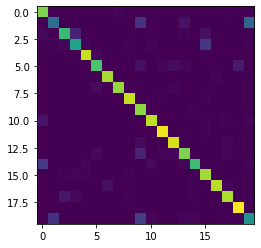

In [6]:
from sklearn.metrics import confusion_matrix

predicted = predict(model)
print(predicted.shape, test_y.shape)
cm = confusion_matrix(test_y, predicted)
print('max output acc:', np.sum(test_y == predicted) / len(test_y))
# print(cm)
plt.imshow(cm)
plt.show()


In [7]:
# classification report results
from sklearn import metrics

print("classification report :", metrics.classification_report(test_y, predicted))

classification report :               precision    recall  f1-score   support

         0.0       0.76      0.96      0.85       103
         1.0       0.70      0.41      0.51       108
         2.0       0.88      0.80      0.84       105
         3.0       0.81      0.71      0.75       102
         4.0       0.96      0.97      0.96       116
         5.0       0.91      0.80      0.85       110
         6.0       0.96      0.98      0.97       109
         7.0       0.98      0.95      0.97       109
         8.0       0.97      0.98      0.98       114
         9.0       0.63      0.99      0.77       103
        10.0       0.94      0.91      0.93       122
        11.0       0.96      0.99      0.98       121
        12.0       0.93      0.95      0.94       121
        13.0       0.88      0.82      0.85       120
        14.0       0.93      0.74      0.83       115
        15.0       0.79      0.95      0.86       112
        16.0       0.98      0.93      0.96       118
   

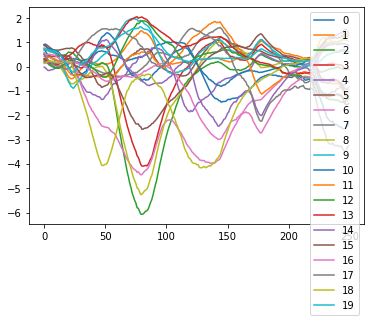

In [11]:

# example
images = tensor_trainX[1, :, :]
images = images.view(-1, seq_dim, input_dim).to(device)


outputs, spike1,spike2,output_mem,fr = model(images)
output_mem = np.array(output_mem).reshape(250, 20)
# output_mem.shape
for i in range(20):
    plt.plot(output_mem[:, i], label=str(i))
plt.legend()
plt.show()


In [14]:
spike1_npy =np.array(spike1).reshape(250,128)
spike2_npy =np.array(spike2).reshape(250,128)
spike1_npy.shape,spike2_npy.shape

((250, 128), (250, 128))

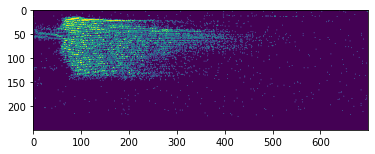

In [22]:
plt.imshow(tensor_trainX[1, :, :])

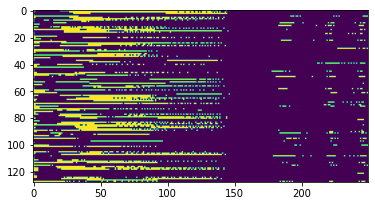

In [16]:
plt.imshow(spike1_npy.T)

In [18]:
# example
spike_count = {'total':[],'fr':[],'per step':[]}
for i in range(len(tensor_testX)):
    images = tensor_testX[i, :, :]
    images = images.view(-1, seq_dim, input_dim).to(device)


    outputs, spike1,spike2,output_mem,fr = model(images)
    spike1_npy =np.array(spike1).reshape(250,128)
    spike2_npy =np.array(spike2).reshape(250,128)
    a = np.zeros((250,256))
    a[:,:128] = spike1_npy
    a[:,128:] = spike2_npy
    spike_count['total'].append(np.sum(a))
    spike_count['fr'].append(fr)
    spike_count['per step'].append(np.mean(np.sum(a,1)))


In [19]:
spike_count_total = np.array(spike_count['total'])
np.mean(spike_count_total),np.max(spike_count_total),np.min(spike_count_total)

(6247.633833922261, 7982.0, 4035.0)

In [20]:
spike_count_total = np.array(spike_count['fr'])
np.mean(spike_count_total)

0.09761927865503534

In [21]:
spike_count_total = np.array(spike_count['per step'])
np.mean(spike_count_total),np.max(spike_count_total),np.min(spike_count_total)

(24.990535335689046, 31.928, 16.14)